In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading the dataset

In [1]:
! wget --no-check-certificate https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.001
! wget --no-check-certificate https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.002
! wget --no-check-certificate https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.003
! wget --no-check-certificate https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.004
! wget --no-check-certificate https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.005

--2022-01-18 13:51:07--  https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.001
Resolving files.inria.fr (files.inria.fr)... 128.93.162.51
Connecting to files.inria.fr (files.inria.fr)|128.93.162.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4294967296 (4.0G)
Saving to: ‘aerialimagelabeling.7z.001’

aerialimagelabeling 100%[===================>]   4.00G  36.3MB/s    in 1m 55s  

2022-01-18 13:53:02 (35.8 MB/s) - ‘aerialimagelabeling.7z.001’ saved [4294967296/4294967296]

--2022-01-18 13:53:02--  https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.002
Resolving files.inria.fr (files.inria.fr)... 128.93.162.51
Connecting to files.inria.fr (files.inria.fr)|128.93.162.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4294967296 (4.0G)
Saving to: ‘aerialimagelabeling.7z.002’

aerialimagelabeling 100%[===================>]   4.00G  36.8MB/s    in 1m 54s  

2022-01-18 13:54:57 (36.0 MB/s) - ‘aerialimagelabe

Combining the zip files

In [2]:
! 7z x aerialimagelabeling.7z.001
! rm -i aerialimagelabeling.7z.* 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4294967296 bytes (4096 MiB)

Extracting archive: aerialimagelabeling.7z.001
  0% 1 Open           --
Path = aerialimagelabeling.7z.001
Type = Split
Physical Size = 4294967296
Volumes = 5
Total Physical Size = 20957265875
----
Path = aerialimagelabeling.7z
Size = 20957265875
--
Path = aerialimagelabeling.7z
Type = 7z
Physical Size = 20957265875
Headers Size = 150
Method = Copy
Solid = -
Blocks = 1

  0%      0% - NEW2-AerialImageDataset.zip                                    1% - NEW2-AerialImageDataset.zip                                    2% - NEW2-Ae

Unzip the dataset

In [3]:
! unzip NEW2-AerialImageDataset.zip
! rm -i NEW2-AerialImageDataset.zip

Archive:  NEW2-AerialImageDataset.zip
   creating: AerialImageDataset/
   creating: AerialImageDataset/test/
   creating: AerialImageDataset/test/images/
  inflating: AerialImageDataset/test/images/bellingham1.tif  
  inflating: AerialImageDataset/test/images/bellingham10.tif  
  inflating: AerialImageDataset/test/images/bellingham11.tif  
  inflating: AerialImageDataset/test/images/bellingham12.tif  
  inflating: AerialImageDataset/test/images/bellingham13.tif  
  inflating: AerialImageDataset/test/images/bellingham14.tif  
  inflating: AerialImageDataset/test/images/bellingham15.tif  
  inflating: AerialImageDataset/test/images/bellingham16.tif  
  inflating: AerialImageDataset/test/images/bellingham17.tif  
  inflating: AerialImageDataset/test/images/bellingham18.tif  
  inflating: AerialImageDataset/test/images/bellingham19.tif  
  inflating: AerialImageDataset/test/images/bellingham2.tif  
  inflating: AerialImageDataset/test/images/bellingham20.tif  
  inflating: AerialImageDatas

# Data Preparation

In [16]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, VerticalFlip, Rotate

In [15]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [17]:
def load_data(path,split=0.2):
  """Load Images and masks"""
  images=sorted(glob(os.path.join(path,"train","images","*.tif")))
  masks=sorted(glob(os.path.join(path,"train","gt","*.tif")))

  """split the data"""
  split_size=int(len(images)*split)
  train_x,valid_x = train_test_split(images, test_size=split_size, random_state=42)
  train_y,valid_y = train_test_split(masks, test_size=split_size, random_state=42)
  
  return (train_x,train_y),(valid_x,valid_y),(images,masks)

Data Augmentation

In [7]:
def augment_data(images,masks,save_path,augment=True):
  """Perform data augmentation""" 
  H=512
  W=512

  for idx,(x,y) in tqdm(enumerate(zip(images,masks)),total=len(images)):
    """Extracting the dir name and image name"""
    name=x.split("/")[-1].split(".")[0]
    
    """Read the image and mask"""
    x=cv2.imread(x, cv2.IMREAD_COLOR)
    y=cv2.imread(y, cv2.IMREAD_COLOR)
    
    if augment == True:
      aug=HorizontalFlip(p=1.0)
      augmented=aug(image=x,mask=y)
      x1=augmented["image"]
      y1=augmented["mask"]

      aug=VerticalFlip(p=1)
      augmented=aug(image=x,mask=y)
      x2=augmented["image"]
      y2=augmented["mask"]

      aug=Rotate(limit=45,p=1)
      augmented=aug(image=x,mask=y)
      x3=augmented["image"]
      y3=augmented["mask"]

      X=[x, x1, x2, x3]
      Y=[y, y1, y2, y3]
    else:
      X=[x]
      Y=[y]
    
    idx=0
    for i,m in zip(X,Y):
      i=cv2.resize(i, (W,H))
      m=cv2.resize(m, (W,H))
      m=m/255.0
      m=(m>0.5)*255

      if len(X)==1:
        tmp_image_name=f"{name}.tif"
        tmp_mask_name=f"{name}.tif"
      else:
        tmp_image_name=f"{name}_{idx}.tif"
        tmp_mask_name=f"{name}_{idx}.tif"

      image_path=os.path.join(save_path,"image/", tmp_image_name)
      mask_path=os.path.join(save_path,"mask/", tmp_mask_name)

      cv2.imwrite(image_path,i)
      cv2.imwrite(mask_path,m)

      idx+=1

In [8]:
def resize_and_save(images,save_path):
  """Perform data augmentation""" 
  H=512
  W=512

  for idx,x in tqdm(enumerate(images),total=len(images)):
    """Extracting the dir name and image name"""
    name=x.split("/")[-1].split(".")[0]
    
    """Read the image and mask"""
    x=cv2.imread(x, cv2.IMREAD_COLOR)
    
    X=[x]
    
    idx=0
    for i in X:
      i=cv2.resize(i, (W,H))

      if len(X)==1:
        tmp_image_name=f"{name}.tif"
        tmp_mask_name=f"{name}.tif"
      else:
        tmp_image_name=f"{name}_{idx}.tif"
        tmp_mask_name=f"{name}_{idx}.tif"

      image_path=os.path.join(save_path,"image/", tmp_image_name)

      cv2.imwrite(image_path,i)

      idx+=1

In [9]:
# remove if the directory already exists
! rm -rf /content/new_data

In [10]:
if __name__=="__main__":
  """seeding"""
  np.random.seed(42)

  data_path="/content/AerialImageDataset"
  (train_x,train_y),(valid_x,valid_y),(images,masks)=load_data(data_path)

  print(f"Train: {len(train_x)} - {len(train_y)}")
  print(f"Test: {len(valid_x)} - {len(valid_y)}")
  
  augment_data(train_x,train_y,"new_data/train/",augment=True)
  augment_data(valid_x,valid_y,"new_data/valid/",augment=False)
  augment_data(valid_x,valid_y,"old_data/test/",augment=False)

Train: 144 - 144
Test: 36 - 36


100%|██████████| 36/36 [00:10<00:00,  3.59it/s]


Resize and load test set

In [11]:
def load_datatest(path,split=0.2):
  """Load Images and masks"""
  test_x=sorted(glob(os.path.join(path,"test","images","*.tif")))
  return test_x
data_path="/content/AerialImageDataset"
test=load_datatest(data_path)
resize_and_save(test,"old_data/test/")

100%|██████████| 180/180 [03:34<00:00,  1.19s/it]


Zip and export new data set to drive

In [12]:
!zip -r new_data.zip /content/new_data

	zip warning: name not matched: /content/new_data

zip error: Nothing to do! (try: zip -r new_data.zip . -i /content/new_data)


Zip and export resized old data set to drive

In [13]:
!zip -r old_data.zip /content/old_data

	zip warning: name not matched: /content/old_data

zip error: Nothing to do! (try: zip -r old_data.zip . -i /content/old_data)


# Model 

In [18]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Input, Concatenate
from tensorflow.keras.models import Model

In [19]:
def conv_block(input,num_filters):
  x=Conv2D(num_filters,3,padding="same")(input)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(num_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  return x

In [20]:
def encoder_block(input, num_filters):
  x=conv_block(input, num_filters)
  p=MaxPool2D((2,2))(x)
  return x, p

In [21]:
def decoder_block(input, skip_features, num_filters):
  x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(input)
  x=Concatenate()([x, skip_features])
  x=conv_block(x,num_filters)
  return x

In [22]:
def build_unet(input_shape):
  inputs=Input(input_shape)

  s1, p1 = encoder_block(inputs,32)
  s2, p2 = encoder_block(p1,64)
  s3, p3 = encoder_block(p2,128)
  s4, p4 = encoder_block(p3,256)

  b1 = conv_block(p4,512)

  d1= decoder_block(b1,s4,256)
  d2= decoder_block(d1,s3,128)
  d3= decoder_block(d2,s2,64)
  d4= decoder_block(d3,s1,32)

  outputs=Conv2D(1,1, padding="same", activation="sigmoid")(d4)

  model=Model(inputs,outputs, name="U-Net")
  return model

In [23]:
if __name__=="__main__":
  input_shape=(512,512,3)
  model=build_unet(input_shape)
  model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Metrics

In [24]:
from tensorflow.keras import backend as K

In [25]:
smooth=1e-15
def iou(y_true,y_pred):
  def f(y_true,y_pred):
    intersection=(y_true*y_pred).sum()
    union=y_true.sum()+y_pred.sum()-intersection
    x=(intersection+smooth)/(union+smooth)
    x=x.astype(np.float32)
    return x
  return tf.numpy_function(f,[y_true,y_pred],tf.float32)
def dice_coef(y_true,y_pred):
  y_true=tf.keras.layers.Flatten()(y_true)
  y_pred=tf.keras.layers.Flatten()(y_pred)
  intersection=tf.reduce_sum(y_true*y_pred)
  return (2. * intersection+smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)
def dice_loss(y_true,y_pred):
  return 1.0 - dice_coef(y_true,y_pred)

# Training

In [26]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall,Precision
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, VerticalFlip, Rotate

In [27]:
H=512
W=512

In [28]:
def shuffling(x,y):
  x,y = shuffle(x, y, random_state=42)
  return x,y

In [29]:
def load_dataset(path):
  """Load Images and masks"""
  x=sorted(glob(os.path.join(path,"image","*.jpg")))
  y=sorted(glob(os.path.join(path,"mask","*.jpg")))
  return x,y

In [30]:
def read_image(path):
  path = path.decode()
  x=cv2.imread(path, cv2.IMREAD_COLOR)
  x=x/255.0
  x=x.astype(np.float32)
  return x

In [31]:
def read_mask(path):
  path = path.decode()
  x=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x=x/255.0
  x=x>0.5
  x=x.astype(np.float32)
  x=np.expand_dims(x, axis=-1)
  return x

In [32]:
def tf_parse(x,y):
  def _parse(x,y):
    x=read_image(x)
    y=read_mask(y)
    return x,y
  x,y =tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  x.set_shape([H, W, 3])
  y.set_shape([H, W, 1])
  return x,y

In [33]:
def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(10)
  return dataset

In [34]:
if __name__=="__main__":
  """Seeding"""
  np.random.seed(42)
  tf.random.set_seed(42)

  """Directory for storing files"""
  create_dir("/content/drive/MyDrive/Dataset/files")

  """Hyperparameters"""
  batch_size=6
  lr=1e-4
  num_epoch=20
  model_path=os.path.join("/content/drive/MyDrive/Dataset/files","model.h5")
  csv_path=os.path.join("/content/drive/MyDrive/Dataset/files","data.csv")

  """Dataset"""
  dataset_path=os.path.join("/content/drive/MyDrive/Dataset/new_data")
  trainpath=os.path.join(dataset_path,"train")
  validpath=os.path.join(dataset_path,"valid")

  train_x,train_y=load_dataset(trainpath)
  train_x,train_y = shuffling(train_x, train_y)
  valid_x,valid_y=load_dataset(validpath)

  print(f"Train:{len(train_x)} - {len(train_y)}")
  print(f"Valid:{len(valid_x)} - {len(valid_y)}")

  train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
  valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

  """Model"""
  model=build_unet((H, W, 3))
  metrics = [dice_coef, iou, Recall(), Precision()]
  model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

  callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
  ]

  model.fit(
    train_dataset,
    epochs=num_epoch,
    validation_data=valid_dataset,
    callbacks=callbacks,
    shuffle=False
  )

Train:576 - 576
Valid:36 - 36
Epoch 1/20
96/96 [==============================] - ETA: 0s - loss: 0.6060 - dice_coef: 0.3940 - iou: 0.2491 - recall: 0.7546 - precision: 0.3229
Epoch 00001: val_loss improved from inf to 0.81548, saving model to /content/drive/MyDrive/Dataset/files/model.h5
96/96 [==============================] - 276s 3s/step - loss: 0.6060 - dice_coef: 0.3940 - iou: 0.2491 - recall: 0.7546 - precision: 0.3229 - val_loss: 0.8155 - val_dice_coef: 0.1845 - val_iou: 0.1035 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/20
96/96 [==============================] - ETA: 0s - loss: 0.5302 - dice_coef: 0.4698 - iou: 0.3099 - recall: 0.8020 - precision: 0.3950
Epoch 00002: val_loss did not improve from 0.81548
96/96 [==============================] - 48s 501ms/step - loss: 0.5302 - dice_coef: 0.4698 - iou: 0.3099 - recall: 0.8020 - precision: 0.3950 - val_loss: 0.8654 - val_dice_coef: 0.1346 - val_iou: 0.0728 - val_recall: 0.0000e+00 - val_precisio

# Evaluation

In [35]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd


In [36]:
def save_results(image,mask,y_pred, save_image_path):
  line=np.ones((H,10,3))*128

  '''Mask'''
  mask = np.expand_dims(mask, axis=-1)
  mask = np.concatenate([mask, mask, mask], axis=-1)

  '''Predicted Mask'''
  y_pred = np.expand_dims(y_pred, axis=-1)
  y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
  y_pred = y_pred*255

  cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
  cv2.imwrite(save_image_path, cat_images)

Results before increasing or decreasing depth

In [37]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Dataset/results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/files/model.h5")

    """ Load the dataset """
    test_x = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/new_data", "valid", "image", "*")))
    test_y = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/new_data", "valid", "mask", "*")))
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Evaluation and Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = mask/255.0
        y = y > 0.5
        y = y.astype(np.int32)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = f"/content/drive/MyDrive/Dataset/results/{name}.png"
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print("")
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/Dataset/files/score.csv")

Test: 36 - 36


100%|██████████| 36/36 [00:28<00:00,  1.27it/s]



Accuracy: 0.90110
F1: 0.63443
Jaccard: 0.47365
Recall: 0.65597
Precision: 0.64988


Results where all the depths are decreased 2x

In [38]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Dataset/results_2x_Decreased")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/files_2x_Decreased/model.h5")

    """ Load the dataset """
    test_x = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/new_data", "valid", "image", "*")))
    test_y = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/new_data", "valid", "mask", "*")))
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Evaluation and Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = mask/255.0
        y = y > 0.5
        y = y.astype(np.int32)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = f"/content/drive/MyDrive/Dataset/results_2x_Decreased/{name}.png"
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print("")
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/Dataset/files_2x_Decreased/score.csv")

Test: 36 - 36


100%|██████████| 36/36 [00:27<00:00,  1.30it/s]



Accuracy: 0.87356
F1: 0.58562
Jaccard: 0.42167
Recall: 0.68380
Precision: 0.54047


Results where all the depths are increased 2x

In [39]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Dataset/results_2x_Increased")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/files_2x_Increased/model.h5")

    """ Load the dataset """
    test_x = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/new_data", "valid", "image", "*")))
    test_y = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/new_data", "valid", "mask", "*")))
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Evaluation and Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = mask/255.0
        y = y > 0.5
        y = y.astype(np.int32)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = f"/content/drive/MyDrive/Dataset/results_2x_Increased/{name}.png"
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print("")
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/Dataset/files_2x_Increased/score.csv")

Test: 36 - 36


100%|██████████| 36/36 [00:32<00:00,  1.10it/s]



Accuracy: 0.91866
F1: 0.67460
Jaccard: 0.51524
Recall: 0.62922
Precision: 0.74643


# Prediction of test data

In [40]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
#import pydicom as dicom
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
#from metrics import dice_loss, dice_coef, iou

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Dataset/test_results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/files/model.h5")

    """ Load the dataset """
    test_x = glob("/content/drive/MyDrive/Dataset/old_data/test/image/*.jpg")
    print(f"Test: {len(test_x)}")

    """ Loop over the data """
    for x in tqdm(test_x):
        """ Extract the names """
        name=x.split("/")[-1].split(".")[0]

        """ Read the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        y_pred = np.expand_dims(y_pred, axis=-1)
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
        y_pred = y_pred*255

        cat_images = np.concatenate([image, y_pred], axis=1)
        cv2.imwrite(f"/content/drive/MyDrive/Dataset/test_results/{name}.png", cat_images)

Test: 180


100%|██████████| 180/180 [01:25<00:00,  2.11it/s]


Results with test data with 2x increased depth


In [41]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Dataset/test_results_2x_Increased")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/files_2x_Increased/model.h5")

    """ Load the dataset """
    test_x = glob("/content/drive/MyDrive/Dataset/old_data/test/image/*.jpg")
    print(f"Test: {len(test_x)}")

    """ Loop over the data """
    for x in tqdm(test_x):
        """ Extract the names """
        name=x.split("/")[-1].split(".")[0]

        """ Read the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        y_pred = np.expand_dims(y_pred, axis=-1)
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
        y_pred = y_pred*255

        cat_images = np.concatenate([image, y_pred], axis=1)
        cv2.imwrite(f"/content/drive/MyDrive/Dataset/test_results_2x_Increased/{name}.png", cat_images)

Test: 180


100%|██████████| 180/180 [01:31<00:00,  1.96it/s]


Results with test data with 2x decreased depth

In [42]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Dataset/test_results_2x_Decreased")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/files_2x_Decreased/model.h5")

    """ Load the dataset """
    test_x = glob("/content/drive/MyDrive/Dataset/old_data/test/image/*.jpg")
    print(f"Test: {len(test_x)}")

    """ Loop over the data """
    for x in tqdm(test_x):
        """ Extract the names """
        name=x.split("/")[-1].split(".")[0]

        """ Read the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        y_pred = np.expand_dims(y_pred, axis=-1)
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
        y_pred = y_pred*255

        cat_images = np.concatenate([image, y_pred], axis=1)
        cv2.imwrite(f"/content/drive/MyDrive/Dataset/test_results_2x_Decreased/{name}.png", cat_images)

Test: 180


100%|██████████| 180/180 [01:19<00:00,  2.25it/s]


# History

In [43]:
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np

In [44]:
BR=np.genfromtxt("/content/drive/MyDrive/Dataset/files/data.csv", delimiter=',', skip_header=1)

Before increasing or decreasing depth

In [45]:
BR=np.ndarray.transpose(BR)

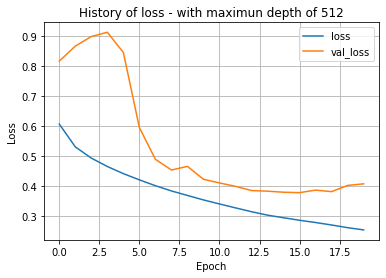

In [46]:
plt.plot(BR[3],label='loss')
plt.plot(BR[9],label='val_loss')
plt.xlabel("Epoch")
plt.title("History of loss - with maximun depth of 512")
plt.ylabel("Loss")
plt.legend()
plt.grid()

After decreasing depth of all layers 2x

In [47]:
BR1=np.genfromtxt("/content/drive/MyDrive/Dataset/files_2x_Decreased/data.csv", delimiter=',', skip_header=1)

In [48]:
BR1=np.ndarray.transpose(BR1)

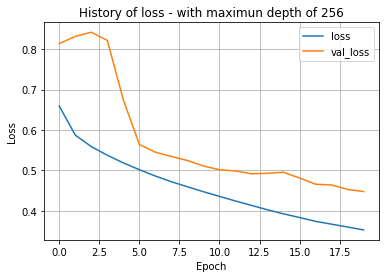

In [49]:
plt.plot(BR1[3],label='loss')
plt.plot(BR1[9],label='val_loss')
plt.xlabel("Epoch")
plt.title("History of loss - with maximun depth of 256")
plt.ylabel("Loss")
plt.legend()
plt.grid()

After increasing depth of all layers 2x

In [50]:
BR2=np.genfromtxt("/content/drive/MyDrive/Dataset/files_2x_Increased/data.csv", delimiter=',', skip_header=1)

In [51]:
BR2=np.ndarray.transpose(BR2)

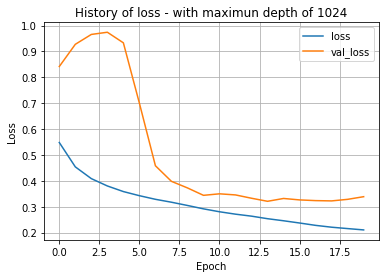

In [52]:
plt.plot(BR2[3],label='loss')
plt.plot(BR2[9],label='val_loss')
plt.xlabel("Epoch")
plt.title("History of loss - with maximun depth of 1024")
plt.ylabel("Loss")
plt.legend()
plt.grid()

In [53]:
BR=np.genfromtxt("/content/drive/MyDrive/Dataset/files/data.csv", delimiter=',', skip_header=1)

Score graphs

In [54]:
Score1=np.genfromtxt("/content/drive/MyDrive/Dataset/files/score.csv", delimiter=',', skip_header=1)
Score2=np.genfromtxt("/content/drive/MyDrive/Dataset/files_2x_Increased/score.csv", delimiter=',', skip_header=1)
Score3=np.genfromtxt("/content/drive/MyDrive/Dataset/files_2x_Decreased/score.csv", delimiter=',', skip_header=1)

In [55]:
Score1=np.ndarray.transpose(Score1)
Score2=np.ndarray.transpose(Score2)
Score3=np.ndarray.transpose(Score3)

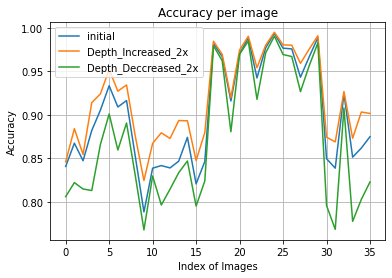

In [56]:
plt.plot(Score1[2],label='initial')
plt.plot(Score2[2],label='Depth_Increased_2x')
plt.plot(Score3[2],label='Depth_Deccreased_2x')
plt.xlabel("Index of Images")
plt.title("Accuracy per image")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

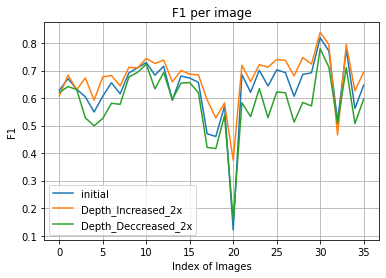

In [57]:
plt.plot(Score1[3],label='initial')
plt.plot(Score2[3],label='Depth_Increased_2x')
plt.plot(Score3[3],label='Depth_Deccreased_2x')
plt.xlabel("Index of Images")
plt.title("F1 per image")
plt.ylabel("F1")
plt.legend()
plt.grid()

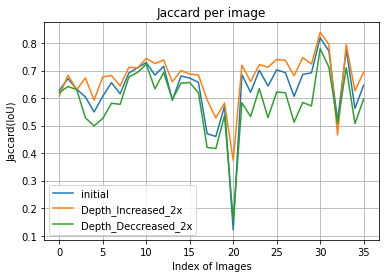

In [58]:
plt.plot(Score1[3],label='initial')
plt.plot(Score2[3],label='Depth_Increased_2x')
plt.plot(Score3[3],label='Depth_Deccreased_2x')
plt.xlabel("Index of Images")
plt.title("Jaccard per image")
plt.ylabel("Jaccard(IoU)")
plt.legend()
plt.grid()

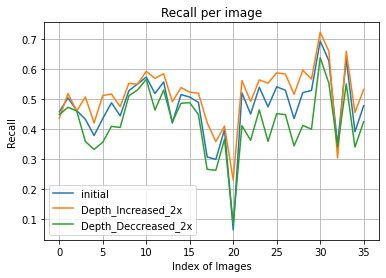

In [59]:
plt.plot(Score1[4],label='initial')
plt.plot(Score2[4],label='Depth_Increased_2x')
plt.plot(Score3[4],label='Depth_Deccreased_2x')
plt.xlabel("Index of Images")
plt.title("Recall per image")
plt.ylabel("Recall")
plt.legend()
plt.grid()

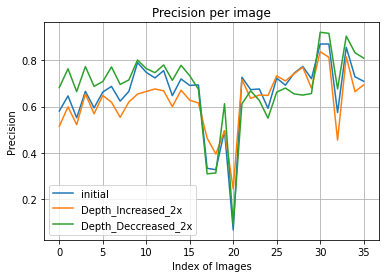

In [60]:
plt.plot(Score1[5],label='initial')
plt.plot(Score2[5],label='Depth_Increased_2x')
plt.plot(Score3[5],label='Depth_Deccreased_2x')
plt.xlabel("Index of Images")
plt.title("Precision per image")
plt.ylabel("Precision")
plt.legend()
plt.grid()